### Note on large .csv files ###
The Reddit Climate Change Dataset (pavellexyr) and Sentiment140 (kazanova) are huge files with over 1 million observations. I cannot upload them to GitHub so here are the links to each one from Kaggle. There is also one dataset that is mentioned but has no associated code: Twitter US Airline Sentiment (crowdflower). This is included below if, for any reason, it is needed in the future.

The Reddit Climate Change Dataset (pavellexyr): https://www.kaggle.com/datasets/pavellexyr/the-reddit-climate-change-dataset

Sentiment140 dataset with 1.6 million tweets (kazanova): https://www.kaggle.com/datasets/kazanova/sentiment140

Twitter US Airline Sentiment (crowdflower): https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [2]:
import numpy as np
import pandas as pd

In [2]:
#not having the limit breaks the kernel. This takes only the first 100K observations per dataset
row_count = 1000
max_obv = 100

In [4]:
pip install langdetect

  Using cached langdetect-1.0.9.tar.gz (981 kB)
  Preparing metadata (setup.py) ... done
  DEPRECATION: langdetect is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for langdetect ... done

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
#https://pypi.org/project/langdetect/

### uncomment this to install, then comment and restart kernel ###
# %%capture
# !pip install langdetect

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
### regex for more lang checking
import re

### (pavellexyr) The Reddit Climate Change Dataset ###
Only using the-reddit-climate-change-dataset-comments.csv which has a column for sentiment for the text. This file alone is over 4GB and processing all of it breaks the kernel so only the first 100K are processed. The columns of interest are 'body' for the comment's body text, and 'sentiment' for the analyzed sentiment per text. NaN values are dropped, leaving a little under 100K usuable observations. 

This is the only dataset that has continuous sentiment values [-1, 1] instead of discrete {-1, 0, 1} so if using ALL of these datasets together as one, it may be biased toward those discrete values than anything in between.

In [51]:
rclimate_text = []
rclimate_sentiment = []
i = 0
for chunk in pd.read_csv('the-reddit-climate-change-dataset-comments.csv', chunksize=row_count):
    if i < max_obv:
        rclimate_text += chunk['body'].tolist()
        rclimate_sentiment += chunk['sentiment'].tolist()
        i += 1
    else:
        break

In [52]:
rclimate_df = pd.DataFrame(data={'text': rclimate_text, 'sentiment': rclimate_sentiment})
rclimate_df = rclimate_df.dropna()
# rclimate_df.shape #expected (98422, 2)

In [44]:
def validate_line(line):
    if not line:
        return np.nan
    if line == "":
        return np.nan
    if not bool(line.strip()):
        return np.nan
    if len(line) < 1:
        return np.nan
    
    if bool(re.match('^(?=.*[a-zA-Z])', line)):
        try:
            if detect(line) != 'en':
                return np.nan
        except LangDetectException:
            return np.nan
    return True

In [42]:
### expect 10 minutes to run for 100k rows
### text_col is df['text']
### sentiment_col is df['sentiment']
### returns three lists of the same length

def check_en(text_col, sentiment_col):
    en_text = text_col.tolist()
    en_sentiment = sentiment_col.tolist()
    lang = []
    
    start = 0
    for i in np.arange(row_count, len(en_text), row_count):
        #observations <1000 at the end will be lost but impact is negligible
        #!!!uncomment print statement below to show progress (recommended)!!!
#         print(start, i)
        lang += [validate_line(x) for x in en_text[start:i]]
        start = i
    print("Finished English check")
    ### all three return values should be of the same length
    return en_text[0:len(lang)], en_sentiment[0:len(lang)], lang

In [ ]:
en_climate_text, en_climate_sentiment, en_climate_lang = check_en(rclimate_df['text'], rclimate_df['sentiment'])
#all should be len 98000

In [ ]:
en_climate_df = pd.DataFrame(data={'text': en_climate_text, 'sentiment': en_climate_sentiment, 'english': en_climate_lang})
en_climate_df = en_climate_df.dropna()
en_climate_df = en_climate_df.drop(columns=['english'])
# print(en_climate_df.shape) #expected (97759, 2)

In [ ]:
def sentiment_to_string(sentiment):
    if type(sentiment) == int or type(sentiment) == float:
        if sentiment < 0:
            return "negative"
        if sentiment > 0:
            return "positive"
        return "neutral"
    else:
        return sentiment

In [ ]:
en_climate_df['sentiment'] = en_climate_df['sentiment'].apply(sentiment_to_string)
# en_climate_df

### (cosmos98) Twitter and Reddit Sentimental analysis Dataset ###
Like with the dataset above, observations are limited to the first 100K and reduced to not have NaN values. Numeric values of {-1, 0, 1} are changed to {negative, neutral, positive} respectively

In [6]:
cosmos_twitter_text = []
cosmos_twitter_sentiment = []
i = 0
for chunk in pd.read_csv('Twitter_Data.csv', chunksize=row_count):
    if i < max_obv:
        cosmos_twitter_text += chunk['clean_text'].tolist()
        cosmos_twitter_sentiment += chunk['category'].tolist()
        i += 1
    else:
        break

cosmos_reddit_text = []
cosmos_reddit_sentiment = []
i = 0
for chunk in pd.read_csv('Reddit_Data.csv', chunksize=row_count):
    if i <max_obv:
        cosmos_reddit_text += chunk['clean_comment'].tolist()
        cosmos_reddit_sentiment += chunk['category'].tolist()
        i += 1
    else:
        break

In [7]:
cosmos_twitter_df = pd.DataFrame(data={'text': cosmos_twitter_text, 'sentiment': cosmos_twitter_sentiment}).dropna()
cosmos_reddit_df = pd.DataFrame(data={'text': cosmos_reddit_text, 'sentiment': cosmos_reddit_sentiment}).dropna()
# cosmos_twitter_df.shape #expected (99999, 2)
# cosmos_reddit_df.shape #expected (37149, 2)

In [8]:
cosmos_twitter_df

,text,sentiment
0,when modi promised “minimum government maximum...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1
...,...,...
99995,only modi theres question compare freebies wit...,0
99996,modi disgrace always people who have expectati...,1
99997,why want vote for modi,0
99998,why didnt people say this intolerance all beca...,0


### (cosmos98) Twitter dataset ###

In [14]:
en_cosmos_twitter_text, en_cosmos_twitter_sentiment, en_cosmos_twitter_lang = check_en(cosmos_twitter_df['text'], cosmos_twitter_df['sentiment'])

Finished English check


In [15]:
en_cosmos_twitter_df = pd.DataFrame(data={'text': en_cosmos_twitter_text, 'sentiment':en_cosmos_twitter_sentiment, 'english':en_cosmos_twitter_lang})
en_cosmos_twitter_df = en_cosmos_twitter_df.dropna()
en_cosmos_twitter_df = en_cosmos_twitter_df.drop(columns=['english'])
print(en_cosmos_twitter_df.shape) #expected (91952, 2)

(91822, 2)


In [16]:
en_cosmos_twitter_df['sentiment'] = en_cosmos_twitter_df['sentiment'].apply(sentiment_to_string)
# en_cosmos_twitter_df

,text,sentiment
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,neutral
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive
...,...,...
98995,india cant survive another term modi,neutral
98996,modi hands down indians are too influenced bol...,negative
98997,rajdeep known congress supporters from day one...,neutral
98998,its bcoz they hate modi thats,negative


### (cosmos98) Reddit dataset

In [17]:
en_cosmos_reddit_text, en_cosmos_reddit_sentiment, en_cosmos_reddit_lang = check_en(cosmos_reddit_df['text'], cosmos_reddit_df['sentiment'])

Finished English check


In [18]:
en_cosmos_reddit_df = pd.DataFrame(data={'text': en_cosmos_reddit_text, 'sentiment': en_cosmos_reddit_sentiment, 'english':en_cosmos_reddit_lang})
en_cosmos_reddit_df = en_cosmos_reddit_df.dropna()
en_cosmos_reddit_df = en_cosmos_reddit_df.drop(columns=['english'])
# print(en_cosmos_reddit_df.shape) #expected (31669, 2)

In [19]:
en_cosmos_reddit_df['sentiment'] = en_cosmos_reddit_df['sentiment'].apply(sentiment_to_string)
# en_cosmos_reddit_df

### NOT USABLE -- (kazanova) Sentiment140 dataset with 1.6 million tweets -- NOT USABLE ###
Dataset originally has 1.6 million tweets, limited to 100K. Dropped NaN values

Unlike the previous datasets, sentiment is recorded as 0=negative, 2=neutral, 4=positive.
However, the target column that is supposed to record this is entirely 0 which is unlikely for a set of 1.6 million tweets. Therefore, the sentiment from this dataset cannot be used with the others. It might be saved for a seperate purpose.

In [20]:
# kazanova_text = []
# kazanova_sentiment = []
# #this dataset used the first observation as the columns
# col_text = 5
# col_sentiment = 0
# i = 0
# for chunk in pd.read_csv('118Adatasets/kazanova_sentiment140.csv', chunksize=row_count):
#     if i < max_obv:
#         kazanova_text += chunk.iloc[:,5].tolist()
#         kazanova_sentiment += chunk.iloc[:,0].tolist()
#         i += 1
#     else:
#         break

In [21]:
# kazanova_df = pd.DataFrame(data={'text':kazanova_text, 'sentiment':kazanova_sentiment})
# kazanova_df['sentiment'].unique()

### NOT USABLE -- (crowdflower) Twitter US Airline Sentiment -- NOT USABLE ###
Dataset has Tweet id for the text, but not the actual text itself. Sentiment is recorded in strings as 'positive', 'negative' and 'neutral' which can be converted to numerical values of 1, -1, and 0 respectively. There is no text readily available in the file so I will not write code for the numeric conversion here. Unlike the kazanova dataset, we likely cannot use this for another purpose without taking significant time to extract the text from the Tweet id for each observation. 

### (tirendazacademy) FIFA World Cup 2022 Tweets ###
Has Tweet text body and sentiment in strings of 'positive', 'negative' and 'neutral' which are unchanged

In [38]:
fifa_text = []
fifa_sentiment = []
i = 0
for chunk in pd.read_csv('fifa_world_cup_2022_tweets.csv', chunksize=row_count):
    if i < max_obv:
        fifa_text += chunk['Tweet'].tolist()
        fifa_sentiment += chunk['Sentiment'].tolist()
        i += 1
    else:
        break

In [39]:
fifa_df = pd.DataFrame(data={'text':fifa_text,'sentiment':fifa_sentiment}).dropna()
# fifa_df

In [45]:
en_fifa_text, en_fifa_sentiment, en_fifa_lang = check_en(fifa_df['text'], fifa_df['sentiment'])

Finished English check


In [46]:
en_fifa_df = pd.DataFrame(data={'text': en_fifa_text, 'sentiment': en_fifa_sentiment, 'english': en_fifa_lang})
en_fifa_df = en_fifa_df.dropna()
en_fifa_df = en_fifa_df.drop(columns=['english'])
# print(en_fifa_df.shape) #expected (21798, 2)

Below are the cleaned DataFrames, having only the columns 'text' (unchanged) and 'sentiment' which has values "positive", "negative" or "neutral". The maximum number of observations per dataset is 100k rows, but any NaN values and text bodies that were not detected to be English (truncated to the nearest thousand) are dropped to make the data more manageable.

In [26]:
# en_climate_df #shape (97759, 2)
# en_cosmos_reddit_df #shape (31669, 2)
# en_cosmos_twitter_df #shape (91952, 2)
# en_fifa_df #shape (21798, 2)

In [4]:
en_climate_df = pd.read_csv('en_climate_df.csv')
en_climate_df

,Unnamed: 0,text,sentiment
0,0,Yeah but what the above commenter is saying is...,positive
1,1,Any comparison of efficiency between solar and...,negative
2,2,I'm honestly waiting for climate change and th...,negative
3,3,Not just Sacramento. It's actually happening a...,neutral
4,4,I think climate change tends to get some peopl...,positive
...,...,...,...
97744,97995,It’s almost like climate change is real. Huh.,positive
97745,97996,I'm not sure I agree. More Americans are consi...,positive
97746,97997,If 40 billion could fix climate change why did...,neutral
97747,97998,"There are a lot of answers to climate change, ...",neutral


### Added from Deepansha ###

In [5]:
#changed variable names from Deepansha's original
X = en_climate_df['text']
Y = en_climate_df['sentiment']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

In [30]:
# countVectorizer.vocabulary_.get('climate')

In [8]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

In [9]:
clf = KNeighborsClassifier(3).fit(X_train, Y_train)

In [60]:
tester = ['yayyy!', 'terrible', "she walked to the right", "woohoo", "I don't feel good", "sad", "feel kinda blue"]
X_new_counts = countVectorizer.transform(tester)
X_new_tfidf = tf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)
predicted

array(['positive', 'negative', 'positive', 'positive', 'positive',
       'negative', 'neutral'], dtype=object)

### Added from Raina ###

In [10]:
# Test with original test set
X_new_counts = countVectorizer.transform(X_test)
X_new_tfidf = tf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)
predicted

array(['positive', 'neutral', 'negative', ..., 'positive', 'positive',
       'negative'], dtype=object)

In [11]:
# Get accuracy on the original test set
correct = 0
passed = 0
for i in range(len(predicted)):
    try:
        if Y_test[i] == predicted[i]:
            correct += 1
    except KeyError:
        passed += 1
        pass
print("correct: ", correct)
print("passed: ", passed)
print("accuracy: ", correct/(len(predicted)-passed))

correct:  6675
passed:  23522
accuracy:  0.4284888945949416


### Test Reddit Climate Change Dataset Trained Model Using Other Datasets ###

In [91]:
# Test with cosmos redit sentiment data
cosmos_reddit_test = pd.read_csv('en_cosmos_reddit_df.csv')
cosmos_reddit_test_data = cosmos_reddit_test['text']
cosmos_reddit_test_data

0         family mormon have never tried explain them t...
1        buddhism has very much lot compatible with chr...
2        seriously don say thing first all they won get...
3        what you have learned yours and only yours wha...
4        for your own benefit you may want read living ...
                               ...                        
31643            coincidentally that how randia works too 
31644               here screen cap his live telecast jpg 
31645              shit forgot today date take upvote sir 
31646     fell for this good one also shows overtly opt...
31647            thought now going ban 2000 rupee note lol
Name: text, Length: 31648, dtype: object

In [92]:
X_new_counts = countVectorizer.transform(cosmos_reddit_test_data)
X_new_tfidf = tf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)
predicted

array(['positive', 'negative', 'negative', ..., 'negative', 'positive',
       'negative'], dtype=object)

In [93]:
cosmos_reddit_test_sentiment = cosmos_reddit_test['sentiment']

correct = 0
passed = 0
for i in range(len(predicted)):
    try:
        if cosmos_reddit_test_sentiment[i] == predicted[i]:
            correct += 1
    except KeyError:
        passed += 1
        pass
print("correct: ", correct)
print("passed: ", passed)
print("accuracy: ", correct/(len(predicted)-passed))

correct:  12522
passed:  0
accuracy:  0.39566481294236605


In [97]:
# Test with cosmos twitter sentiment data
cosmos_twitter_test = pd.read_csv('en_cosmos_twitter_df.csv')
cosmos_twitter_test_data = cosmos_twitter_test['text']
cosmos_twitter_test_data

0        when modi promised “minimum government maximum...
1        talk all the nonsense and continue all the dra...
2        what did just say vote for modi  welcome bjp t...
3        asking his supporters prefix chowkidar their n...
4        answer who among these the most powerful world...
                               ...                        
91953                 india cant survive another term modi
91954    modi hands down indians are too influenced bol...
91955    rajdeep known congress supporters from day one...
91956                       its bcoz they hate modi thats 
91957    narendra modi begin campaign trail address pub...
Name: text, Length: 91958, dtype: object

In [98]:
X_new_counts = countVectorizer.transform(cosmos_twitter_test_data)
X_new_tfidf = tf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)
predicted

array(['negative', 'negative', 'negative', ..., 'positive', 'negative',
       'neutral'], dtype=object)

In [99]:
cosmos_twitter_test_sentiment = cosmos_twitter_test['sentiment']

correct = 0
passed = 0
for i in range(len(predicted)):
    try:
        if cosmos_twitter_test_sentiment[i] == predicted[i]:
            correct += 1
    except KeyError:
        passed += 1
        pass
print("correct: ", correct)
print("passed: ", passed)
print("accuracy: ", correct/(len(predicted)-passed))

correct:  32575
passed:  0
accuracy:  0.3542378042149677


In [100]:
# Test with fifa twitter data
fifa_test = pd.read_csv('en_fifa_df.csv')
fifa_test_data = fifa_test['text']
fifa_test_data

0        What are we drinking today @TucanTribe \n@MadB...
1        Amazing @CanadaSoccerEN  #WorldCup2022 launch ...
2        Worth reading while watching #WorldCup2022 htt...
3        Golden Maknae shinning bright\n\nhttps://t.co/...
4        If the BBC cares so much about human rights, h...
                               ...                        
21793    Leave #FIFA alone! Let the #soccer prevail and...
21794    Three stars on this logo after WC\n#WorldCup20...
21795    What is really sickening is the west trying to...
21796    Messi’s last World Cup! I am going with Argent...
21797    Who will win the World Cup 2022?\n🏆⚽️\n\n@FIFA...
Name: text, Length: 21798, dtype: object

In [101]:
X_new_counts = countVectorizer.transform(fifa_test_data)
X_new_tfidf = tf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)
predicted

array(['negative', 'positive', 'positive', ..., 'positive', 'positive',
       'positive'], dtype=object)

In [102]:
fifa_test_sentiment = fifa_test['sentiment']

correct = 0
passed = 0
for i in range(len(predicted)):
    try:
        if fifa_test_sentiment[i] == predicted[i]:
            correct += 1
    except KeyError:
        passed += 1
        pass
print("correct: ", correct)
print("passed: ", passed)
print("accuracy: ", correct/(len(predicted)-passed))

correct:  7799
passed:  0
accuracy:  0.3577851179007248


### Train on Different Datasets ###

##### Twitter Sentiment Analysis #####

In [9]:
cosmos_twitter_df

,text,sentiment
0,when modi promised “minimum government maximum...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1
...,...,...
99995,only modi theres question compare freebies wit...,0
99996,modi disgrace always people who have expectati...,1
99997,why want vote for modi,0
99998,why didnt people say this intolerance all beca...,0


In [18]:
cosmos_twitter_df["sentiment"] = cosmos_twitter_df["sentiment"].apply(lambda curr: "negative" if float(curr) < 0 else ("positive" if float(curr) > 0 else "neutral"))
cosmos_twitter_df

,text,sentiment
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,neutral
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive
...,...,...
99995,only modi theres question compare freebies wit...,neutral
99996,modi disgrace always people who have expectati...,positive
99997,why want vote for modi,neutral
99998,why didnt people say this intolerance all beca...,neutral


In [19]:
X = cosmos_twitter_df['text']
Y = cosmos_twitter_df['sentiment']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

In [22]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

In [23]:
clf = KNeighborsClassifier(3).fit(X_train, Y_train)

In [24]:
tester = ['yayyy!', 'terrible', "she walked to the right", "woohoo", "I don't feel good", "sad", "feel kinda blue"]
X_new_counts = countVectorizer.transform(tester)
X_new_tfidf = tf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)
predicted

array(['neutral', 'neutral', 'neutral', 'neutral', 'positive', 'negative',
       'neutral'], dtype=object)

##### Reddit Sentiment Analysis #####

In [ ]:
cosmos_reddit_df["sentiment"] = cosmos_reddit_df["sentiment"].apply(lambda curr: "negative" if float(curr) < 0 else ("positive" if float(curr) > 0 else "neutral"))

In [28]:
cosmos_reddit_df

,text,sentiment
0,family mormon have never tried explain them t...,positive
1,buddhism has very much lot compatible with chr...,positive
2,seriously don say thing first all they won get...,negative
3,what you have learned yours and only yours wha...,neutral
4,for your own benefit you may want read living ...,positive
...,...,...
37244,jesus,neutral
37245,kya bhai pure saal chutiya banaya modi aur jab...,positive
37246,downvote karna tha par upvote hogaya,neutral
37247,haha nice,positive


In [36]:
X = cosmos_reddit_df['text']
Y = cosmos_reddit_df['sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

clf = KNeighborsClassifier(3).fit(X_train, Y_train)

In [37]:
tester = ['yayyy!', 'terrible', "she walked to the right", "woohoo", "I don't feel good", "sad", "feel kinda blue"]
X_new_counts = countVectorizer.transform(tester)
X_new_tfidf = tf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)
predicted

array(['neutral', 'negative', 'positive', 'neutral', 'positive',
       'negative', 'neutral'], dtype=object)

#### FIFA Dataset ####

In [47]:
en_fifa_df

,text,sentiment
0,What are we drinking today @TucanTribe \n@MadB...,neutral
1,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,Worth reading while watching #WorldCup2022 htt...,positive
4,"If the BBC cares so much about human rights, h...",negative
5,"And like, will the mexican fans be able to scr...",negative
...,...,...
21995,Leave #FIFA alone! Let the #soccer prevail and...,positive
21996,Three stars on this logo after WC\n#WorldCup20...,positive
21997,What is really sickening is the west trying to...,negative
21998,Messi’s last World Cup! I am going with Argent...,positive


In [48]:
X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

clf = KNeighborsClassifier(3).fit(X_train, Y_train)

In [49]:
tester = ['yayyy!', 'terrible', "she walked to the right", "woohoo", "I don't feel good", "sad", "feel kinda blue"]
X_new_counts = countVectorizer.transform(tester)
X_new_tfidf = tf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)
predicted

array(['negative', 'negative', 'neutral', 'positive', 'positive',
       'negative', 'negative'], dtype=object)

In [173]:
from matplotlib import pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(clf, X_train, Y_train, model_name):
    # plot learning curve
    train_sizes, train_scores, test_scores = learning_curve(clf, X_train, Y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel(model_name + " Model Learning Curve")
    plt.ylabel("Score")
    plt.legend(loc="best")
    # save plot
    plt.savefig(model_name + "Model Learning Curve.png")
    plt.show()

In [117]:
from sklearn import metrics
from sklearn.metrics import classification_report

def test_and_plot_model(clf, X_test, Y_test, X_train, Y_train, model_name):
    X_new_counts = countVectorizer.transform(X_test)
    X_new_tfidf = tf_transformer.transform(X_new_counts)
    predicted = clf.predict(X_new_tfidf)
    classification_report = metrics.classification_report(Y_test, predicted)
    print(classification_report)
    plot_learning_curve(clf, X_train, Y_train, model_name)
    return classification_report

In [121]:
from sklearn import metrics

def get_classification_report(clf, X_test, Y_test):
    X_new_counts = countVectorizer.transform(X_test)
    X_new_tfidf = tf_transformer.transform(X_new_counts)
    predicted = clf.predict(X_new_tfidf)
    classification_report = metrics.classification_report(Y_test, predicted)
    print(classification_report)
    return classification_report

In [58]:
# en_climate_df = pd.read_csv('en_climate_df.csv')

# X = en_climate_df['text']
# Y = en_climate_df['sentiment']

en_fifa_df = pd.read_csv('new_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

# use svm to classify
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

clf_svm = SVC().fit(X_train, Y_train)

tester = ['yayyy!', 'terrible', "she walked to the right", "woohoo", "I don't feel good", "sad", "feel kinda blue"]
X_new_counts = countVectorizer.transform(tester)
X_new_tfidf = tf_transformer.transform(X_new_counts)
predicted = clf_svm.predict(X_new_tfidf)
predicted

array(['neutral', 'neutral', 'positive', 'neutral', 'positive', 'neutral',
       'negative'], dtype=object)

              precision    recall  f1-score   support

    negative       0.72      0.65      0.68      2281
     neutral       0.64      0.68      0.66      3188
    positive       0.73      0.74      0.74      3251

    accuracy                           0.69      8720
   macro avg       0.70      0.69      0.69      8720
weighted avg       0.69      0.69      0.69      8720



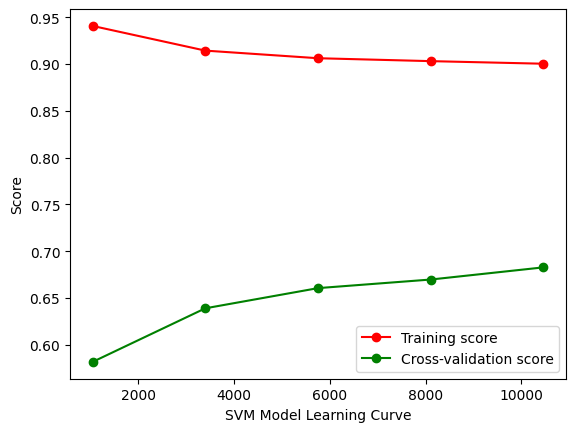

In [59]:
test_and_plot_model(clf_svm, X_test, Y_test, "SVM")

              precision    recall  f1-score   support

    negative       0.71      0.71      0.71      2281
     neutral       0.67      0.67      0.67      3188
    positive       0.75      0.76      0.76      3251

    accuracy                           0.71      8720
   macro avg       0.71      0.71      0.71      8720
weighted avg       0.71      0.71      0.71      8720



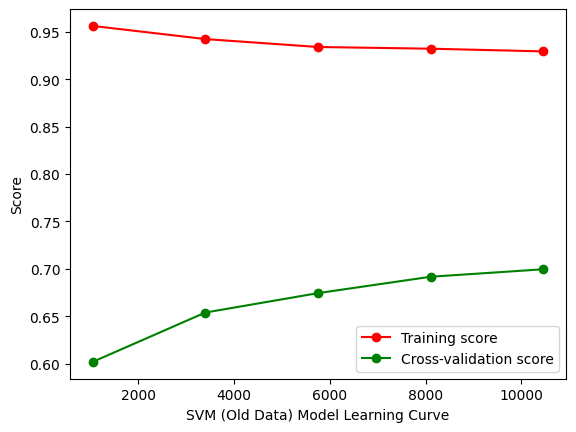

In [60]:
en_fifa_df = pd.read_csv('en_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

# use svm to classify
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

clf_svm_old = SVC().fit(X_train, Y_train)

test_and_plot_model(clf_svm_old, X_test, Y_test, "SVM (Old Data)")

In [8]:
# test using a different dataset
# cosmos reddit sentiment data
cosmos_reddit_test = pd.read_csv('en_cosmos_reddit_df.csv')
cosmos_reddit_test_data = cosmos_reddit_test['text']
cosmos_reddit_test_data

X_new_counts = countVectorizer.transform(cosmos_reddit_test_data)
X_new_tfidf = tf_transformer.transform(X_new_counts)
predicted = clf_svm.predict(X_new_tfidf)
predicted

cosmos_reddit_test_sentiment = cosmos_reddit_test['sentiment']

In [9]:
# scoring
from sklearn.metrics import classification_report
print(classification_report(cosmos_reddit_test_sentiment, predicted))

              precision    recall  f1-score   support

    negative       0.29      0.90      0.44      7835
     neutral       0.56      0.27      0.36      8887
    positive       0.77      0.18      0.29     14926

    accuracy                           0.38     31648
   macro avg       0.54      0.45      0.37     31648
weighted avg       0.59      0.38      0.35     31648



In [11]:
# cosmos twitter sentiment data
cosmos_twitter_test = pd.read_csv('en_cosmos_twitter_df.csv')
cosmos_twitter_test_data = cosmos_twitter_test['text']
cosmos_twitter_test_data

X_new_counts = countVectorizer.transform(cosmos_twitter_test_data)
X_new_tfidf = tf_transformer.transform(X_new_counts)
predicted = clf_svm.predict(X_new_tfidf)
predicted

cosmos_twitter_test_sentiment = cosmos_twitter_test['sentiment']

# scoring
from sklearn.metrics import classification_report
print(classification_report(cosmos_twitter_test_sentiment, predicted))

              precision    recall  f1-score   support

    negative       0.28      0.82      0.42     21005
     neutral       0.46      0.30      0.36     28907
    positive       0.76      0.22      0.34     42046

    accuracy                           0.38     91958
   macro avg       0.50      0.45      0.37     91958
weighted avg       0.56      0.38      0.36     91958



The generalisation is still not good for the svm classifier, however, when testing on the same dataset we can see the overall accuracy is quite high (0.71).

==============================================================================================================================================================================

Random forest

In [40]:
en_fifa_df = pd.read_csv('new_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use random forest
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0).fit(X_train, Y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      2281
     neutral       0.60      0.14      0.23      3188
    positive       0.40      0.98      0.57      3251

    accuracy                           0.42      8720
   macro avg       0.33      0.37      0.26      8720
weighted avg       0.37      0.42      0.29      8720



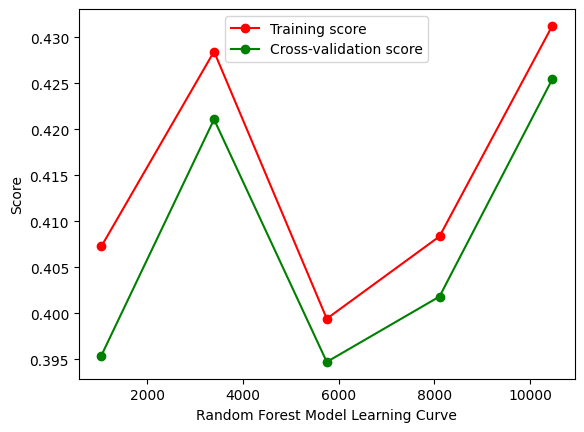

In [41]:
test_and_plot_model(clf_rf, X_test, Y_test, "Random Forest")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      2281
     neutral       0.65      0.11      0.19      3188
    positive       0.39      0.97      0.55      3251

    accuracy                           0.40      8720
   macro avg       0.35      0.36      0.25      8720
weighted avg       0.38      0.40      0.27      8720



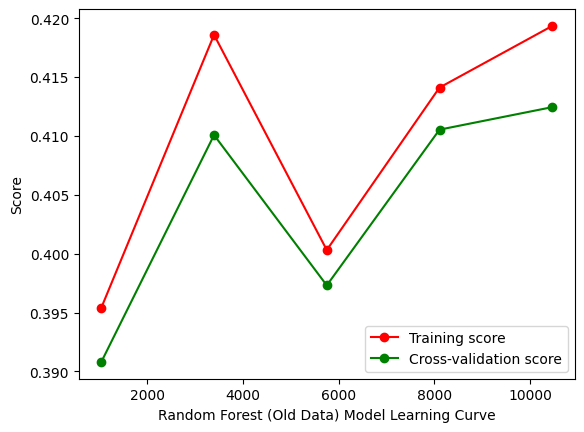

In [61]:
en_fifa_df = pd.read_csv('en_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use random forest
from sklearn.ensemble import RandomForestClassifier
clf_rf_old = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0).fit(X_train, Y_train)

test_and_plot_model(clf_rf_old, X_test, Y_test, "Random Forest (Old Data)")

Logistic regression

In [42]:
en_fifa_df = pd.read_csv('new_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use logistic regression
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, Y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      2281
     neutral       0.60      0.14      0.23      3188
    positive       0.40      0.98      0.57      3251

    accuracy                           0.42      8720
   macro avg       0.33      0.37      0.26      8720
weighted avg       0.37      0.42      0.29      8720



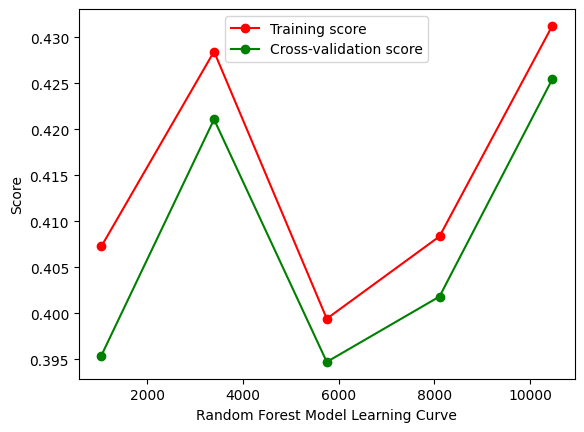

In [43]:
test_and_plot_model(clf_rf, X_test, Y_test, "Random Forest")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.72      0.69      0.71      2281
     neutral       0.67      0.66      0.66      3188
    positive       0.73      0.77      0.75      3251

    accuracy                           0.71      8720
   macro avg       0.71      0.71      0.71      8720
weighted avg       0.71      0.71      0.71      8720



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

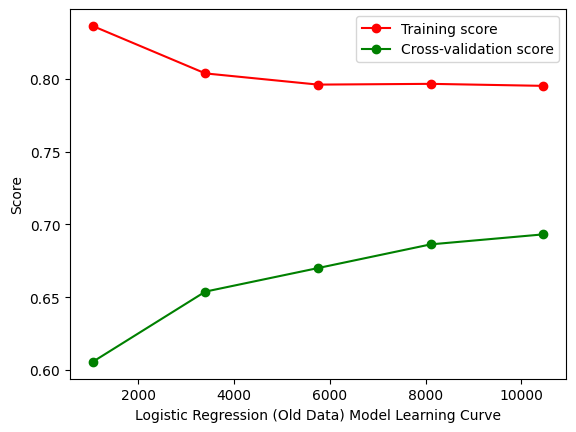

In [174]:
en_fifa_df = pd.read_csv('en_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use logistic regression
from sklearn.linear_model import LogisticRegression
clf_lr_old = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, Y_train)

get_classification_report(clf_lr_old, X_test, Y_test)

plot_learning_curve(clf_lr_old, X_train, Y_train, "Logistic Regression (Old Data)")

Decision tree

In [45]:
en_fifa_df = pd.read_csv('new_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use decision tree
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(random_state=0).fit(X_train, Y_train)

              precision    recall  f1-score   support

    negative       0.56      0.49      0.52      2281
     neutral       0.54      0.56      0.55      3188
    positive       0.61      0.64      0.62      3251

    accuracy                           0.57      8720
   macro avg       0.57      0.56      0.57      8720
weighted avg       0.57      0.57      0.57      8720



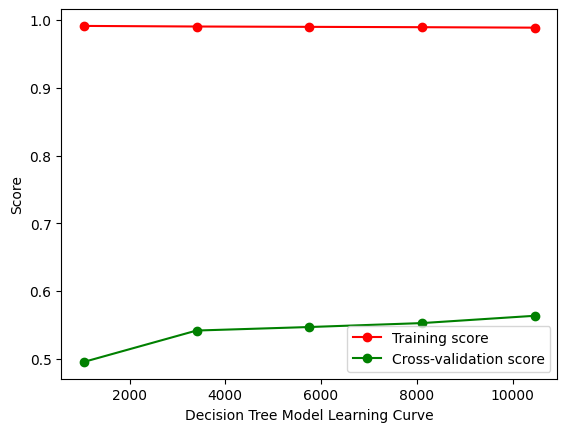

In [46]:
test_and_plot_model(clf_dt, X_test, Y_test, "Decision Tree")

              precision    recall  f1-score   support

    negative       0.55      0.54      0.55      2281
     neutral       0.55      0.56      0.55      3188
    positive       0.61      0.62      0.62      3251

    accuracy                           0.57      8720
   macro avg       0.57      0.57      0.57      8720
weighted avg       0.57      0.57      0.57      8720



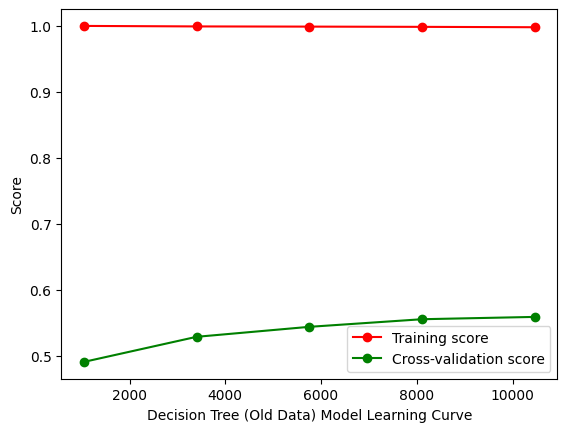

In [63]:
en_fifa_df = pd.read_csv('en_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use decision tree
from sklearn.tree import DecisionTreeClassifier
clf_dt_old = DecisionTreeClassifier(random_state=0).fit(X_train, Y_train)

test_and_plot_model(clf_dt_old, X_test, Y_test, "Decision Tree (Old Data)")

KNN

              precision    recall  f1-score   support

    negative       0.53      0.49      0.51      2281
     neutral       0.53      0.56      0.55      3188
    positive       0.61      0.60      0.61      3251

    accuracy                           0.56      8720
   macro avg       0.56      0.55      0.55      8720
weighted avg       0.56      0.56      0.56      8720



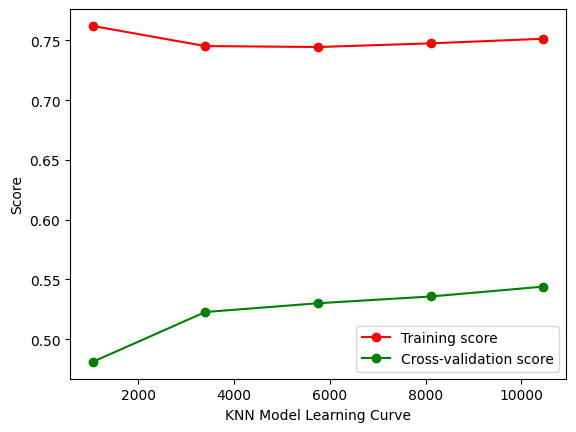

In [50]:
en_fifa_df = pd.read_csv('new_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use knn
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(3).fit(X_train, Y_train)

test_and_plot_model(clf_knn, X_test, Y_test, "KNN")

              precision    recall  f1-score   support

    negative       0.54      0.52      0.53      2281
     neutral       0.58      0.54      0.56      3188
    positive       0.60      0.66      0.63      3251

    accuracy                           0.58      8720
   macro avg       0.57      0.57      0.57      8720
weighted avg       0.58      0.58      0.58      8720



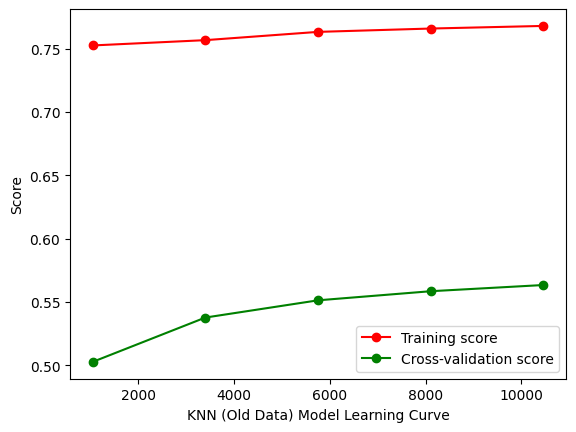

In [65]:
en_fifa_df = pd.read_csv('en_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use knn
from sklearn.neighbors import KNeighborsClassifier
clf_knn_old = KNeighborsClassifier(3).fit(X_train, Y_train)

test_and_plot_model(clf_knn_old, X_test, Y_test, "KNN (Old Data)")

Perceptron

              precision    recall  f1-score   support

    negative       0.67      0.67      0.67      2281
     neutral       0.63      0.59      0.61      3188
    positive       0.69      0.74      0.71      3251

    accuracy                           0.66      8720
   macro avg       0.66      0.66      0.66      8720
weighted avg       0.66      0.66      0.66      8720



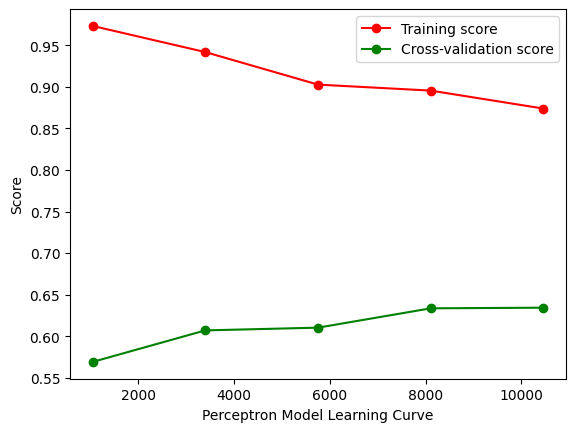

In [51]:
en_fifa_df = pd.read_csv('new_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use perceptron
from sklearn.linear_model import Perceptron
clf_ptr = Perceptron(tol=1e-3, random_state=0).fit(X_train, Y_train)

test_and_plot_model(clf_ptr, X_test, Y_test, "Perceptron")

              precision    recall  f1-score   support

    negative       0.72      0.68      0.70      2281
     neutral       0.65      0.64      0.64      3188
    positive       0.72      0.76      0.74      3251

    accuracy                           0.69      8720
   macro avg       0.70      0.69      0.69      8720
weighted avg       0.69      0.69      0.69      8720



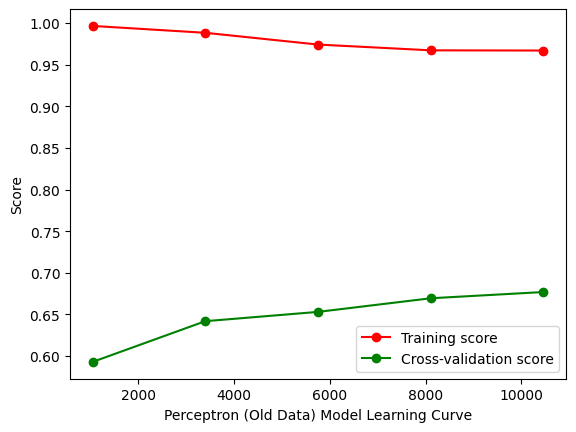

In [66]:
en_fifa_df = pd.read_csv('en_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use perceptron
from sklearn.linear_model import Perceptron
clf_ptr_old = Perceptron(tol=1e-3, random_state=0).fit(X_train, Y_train)

test_and_plot_model(clf_ptr_old, X_test, Y_test, "Perceptron (Old Data)")

SDG

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reache

              precision    recall  f1-score   support

    negative       0.65      0.75      0.70      2281
     neutral       0.68      0.56      0.61      3188
    positive       0.71      0.75      0.73      3251

    accuracy                           0.68      8720
   macro avg       0.68      0.69      0.68      8720
weighted avg       0.68      0.68      0.68      8720



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


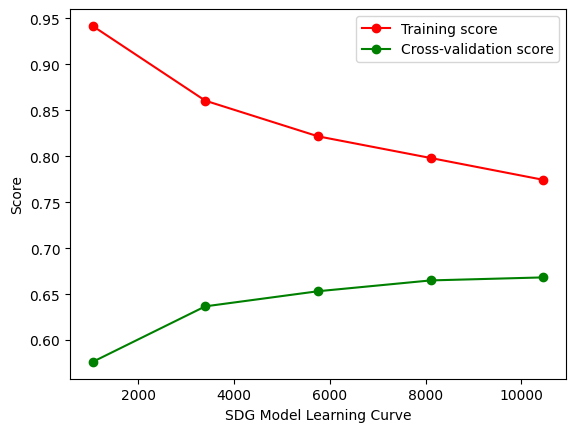

In [53]:
en_fifa_df = pd.read_csv('new_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use sdg
from sklearn.linear_model import SGDClassifier
clf_sdg = SGDClassifier(loss="hinge", penalty="l2", max_iter=5).fit(X_train, Y_train)

test_and_plot_model(clf_sdg, X_test, Y_test, "SDG")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reache

              precision    recall  f1-score   support

    negative       0.69      0.75      0.72      2281
     neutral       0.72      0.58      0.64      3188
    positive       0.72      0.81      0.76      3251

    accuracy                           0.71      8720
   macro avg       0.71      0.71      0.71      8720
weighted avg       0.71      0.71      0.71      8720



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reache

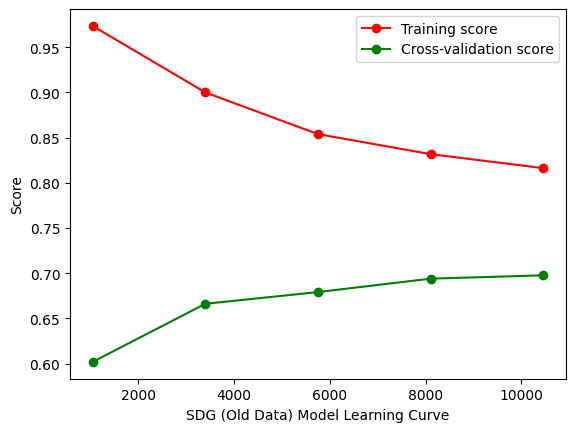

In [73]:
en_fifa_df = pd.read_csv('en_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use sdg
from sklearn.linear_model import SGDClassifier
clf_sdg_old = SGDClassifier(loss="hinge", penalty="l2", max_iter=5).fit(X_train, Y_train)

test_and_plot_model(clf_sdg_old, X_test, Y_test, "SDG (Old Data)")

Neural Network

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      2281
     neutral       0.00      0.00      0.00      3188
    positive       0.37      1.00      0.54      3251

    accuracy                           0.37      8720
   macro avg       0.12      0.33      0.18      8720
weighted avg       0.14      0.37      0.20      8720



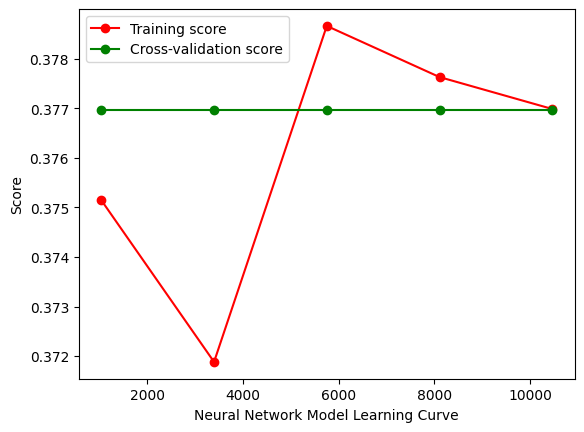

In [54]:
en_fifa_df = pd.read_csv('new_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use neural network
from sklearn.neural_network import MLPClassifier
clf_nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_train, Y_train)

test_and_plot_model(clf_nn, X_test, Y_test, "Neural Network")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


              precision    recall  f1-score   support

    negative       0.70      0.70      0.70      2281
     neutral       0.48      0.51      0.50      3188
    positive       0.63      0.59      0.61      3251

    accuracy                           0.59      8720
   macro avg       0.61      0.60      0.60      8720
weighted avg       0.60      0.59      0.59      8720



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network

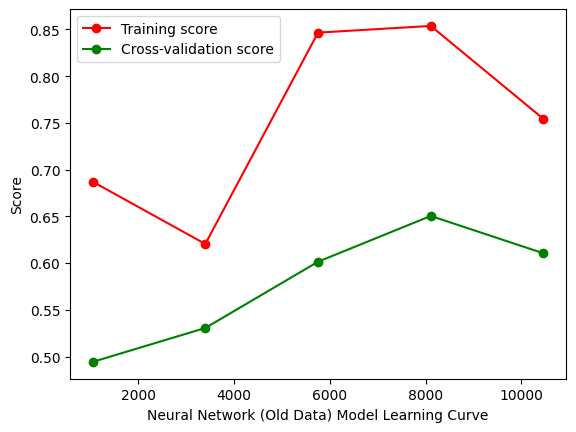

In [74]:
en_fifa_df = pd.read_csv('en_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use neural network
from sklearn.neural_network import MLPClassifier
clf_nn_old = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_train, Y_train)

test_and_plot_model(clf_nn_old, X_test, Y_test, "Neural Network (Old Data)")

Gradient boosting

              precision    recall  f1-score   support

    negative       0.74      0.58      0.65      2281
     neutral       0.60      0.68      0.64      3188
    positive       0.70      0.70      0.70      3251

    accuracy                           0.66      8720
   macro avg       0.68      0.66      0.66      8720
weighted avg       0.67      0.66      0.66      8720



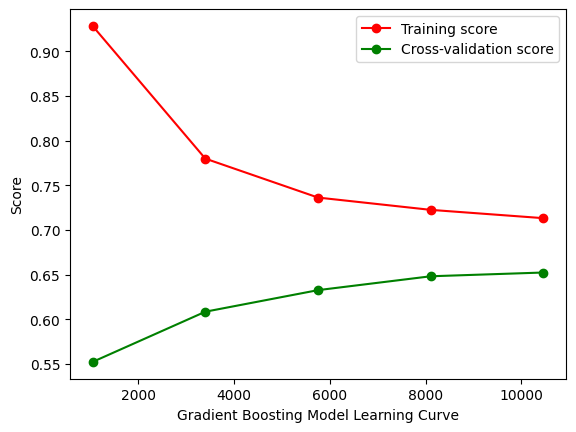

In [55]:
en_fifa_df = pd.read_csv('new_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, Y_train)

test_and_plot_model(clf_gb, X_test, Y_test, "Gradient Boosting")

              precision    recall  f1-score   support

    negative       0.72      0.63      0.67      2281
     neutral       0.62      0.67      0.65      3188
    positive       0.71      0.72      0.71      3251

    accuracy                           0.68      8720
   macro avg       0.69      0.67      0.68      8720
weighted avg       0.68      0.68      0.68      8720



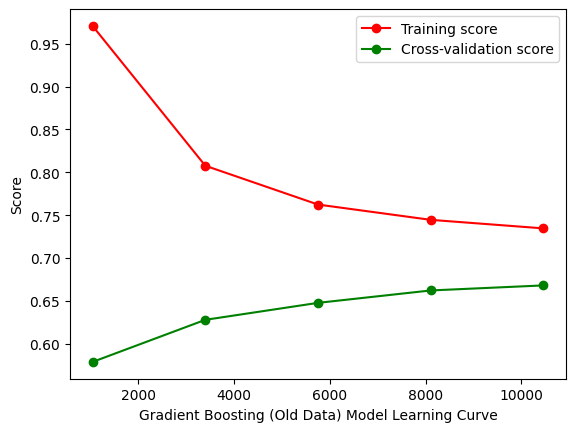

In [75]:
en_fifa_df = pd.read_csv('en_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
clf_gb_old = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, Y_train)

test_and_plot_model(clf_gb_old, X_test, Y_test, "Gradient Boosting (Old Data)")

Adaboost

              precision    recall  f1-score   support

    negative       0.69      0.58      0.63      2281
     neutral       0.55      0.70      0.61      3188
    positive       0.71      0.60      0.65      3251

    accuracy                           0.63      8720
   macro avg       0.65      0.63      0.63      8720
weighted avg       0.65      0.63      0.63      8720



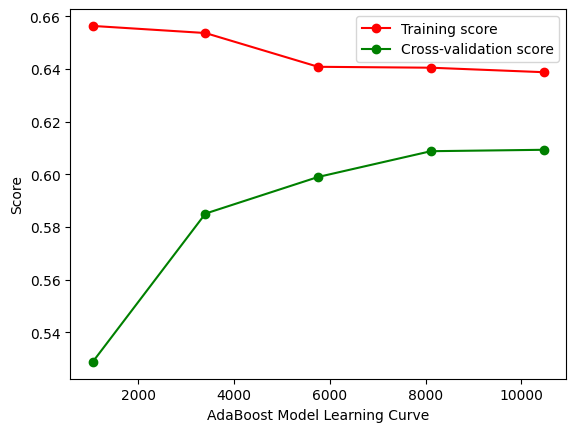

In [56]:
en_fifa_df = pd.read_csv('new_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use adaboost
from sklearn.ensemble import AdaBoostClassifier
clf_ab = AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train, Y_train)

test_and_plot_model(clf_ab, X_test, Y_test, "AdaBoost")

              precision    recall  f1-score   support

    negative       0.68      0.60      0.64      2281
     neutral       0.56      0.68      0.61      3188
    positive       0.71      0.62      0.66      3251

    accuracy                           0.64      8720
   macro avg       0.65      0.63      0.64      8720
weighted avg       0.65      0.64      0.64      8720



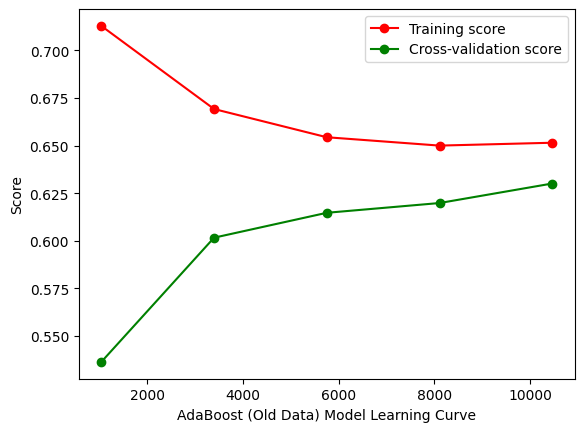

In [76]:
en_fifa_df = pd.read_csv('en_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use adaboost
from sklearn.ensemble import AdaBoostClassifier
clf_ab_old = AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train, Y_train)

test_and_plot_model(clf_ab_old, X_test, Y_test, "AdaBoost (Old Data)")

Naive bayes

              precision    recall  f1-score   support

    negative       0.77      0.54      0.63      2281
     neutral       0.61      0.64      0.63      3188
    positive       0.67      0.78      0.72      3251

    accuracy                           0.67      8720
   macro avg       0.68      0.65      0.66      8720
weighted avg       0.67      0.67      0.66      8720



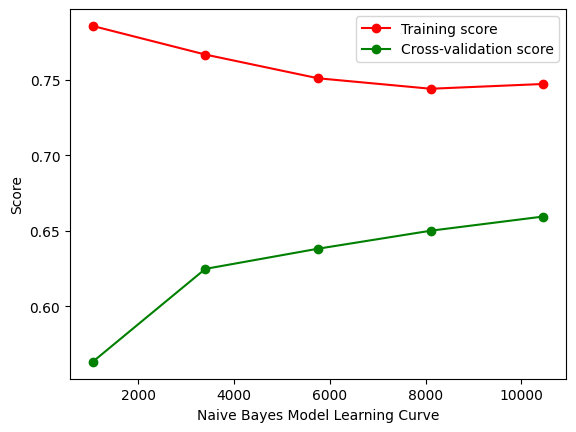

In [57]:
en_fifa_df = pd.read_csv('new_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use naive bayes
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB().fit(X_train, Y_train)

test_and_plot_model(clf_nb, X_test, Y_test, "Naive Bayes")

              precision    recall  f1-score   support

    negative       0.77      0.51      0.61      2281
     neutral       0.64      0.60      0.62      3188
    positive       0.65      0.84      0.73      3251

    accuracy                           0.67      8720
   macro avg       0.68      0.65      0.65      8720
weighted avg       0.68      0.67      0.66      8720



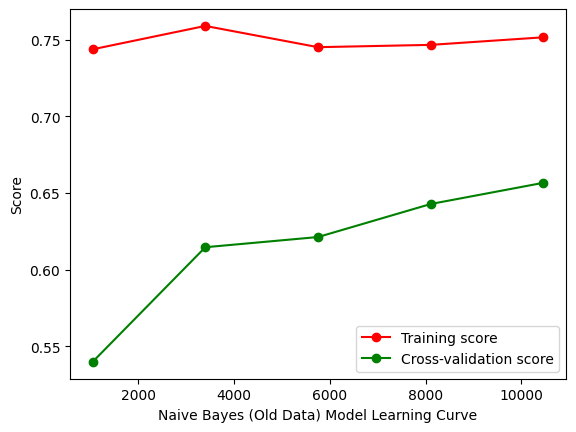

In [77]:
en_fifa_df = pd.read_csv('en_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use naive bayes
from sklearn.naive_bayes import MultinomialNB
clf_nb_old = MultinomialNB().fit(X_train, Y_train)

test_and_plot_model(clf_nb_old, X_test, Y_test, "Naive Bayes (Old Data)")

              precision    recall  f1-score   support

    negative       0.70      0.73      0.71      2281
     neutral       0.66      0.64      0.65      3188
    positive       0.74      0.74      0.74      3251

    accuracy                           0.70      8720
   macro avg       0.70      0.70      0.70      8720
weighted avg       0.70      0.70      0.70      8720



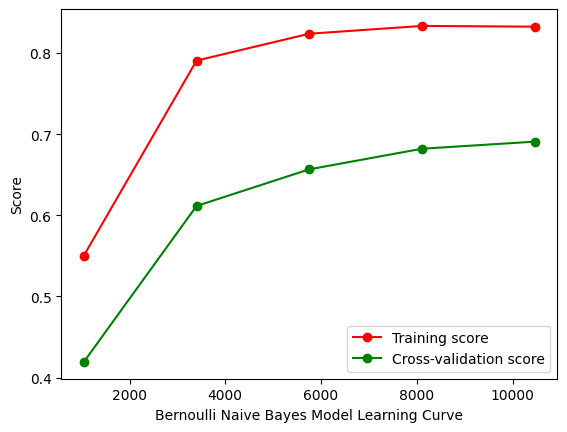

In [82]:
en_fifa_df = pd.read_csv('en_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# # use bernoulli naive bayes
from sklearn.naive_bayes import BernoulliNB
clf_bnb = BernoulliNB().fit(X_train, Y_train)

test_and_plot_model(clf_bnb, X_test, Y_test, "Bernoulli Naive Bayes")

              precision    recall  f1-score   support

    negative       0.74      0.73      0.74      2281
     neutral       0.69      0.67      0.68      3188
    positive       0.75      0.78      0.77      3251

    accuracy                           0.73      8720
   macro avg       0.73      0.73      0.73      8720
weighted avg       0.73      0.73      0.73      8720



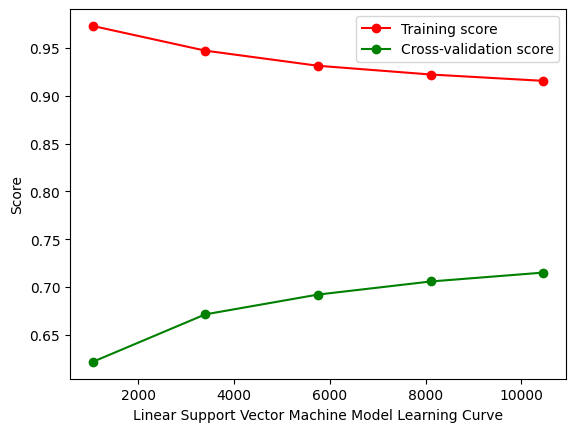

In [84]:
en_fifa_df = pd.read_csv('en_fifa_df.csv')

X = en_fifa_df['text']
Y = en_fifa_df['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use linear support vector machine
from sklearn.svm import LinearSVC
clf_lsvm = LinearSVC(random_state=0, tol=1e-5).fit(X_train, Y_train)

test_and_plot_model(clf_lsvm, X_test, Y_test, "Linear Support Vector Machine")

From the above experiments, we can see the linear support vector machine generate the best accuracy. However, the generalisaton error is still high on unseen data. The above models were all trained on a smaller dataset the fifa tweets dataset to validate the models' accuracies, as it saves time. The below models will be trained on the largest dataset we have, the climate twitter dataset, to see if the generalisation error can be reduced. Due to time limits, we will only train the models with the best accuracy from the above experiments below, which are: Support Vector Machine, Linear Support Vector machine, SDG and Logistic Regression. These three models all have a >= 0.70 accuracy on validation data.

### Train on the climate dataset ###

Linear support vector machine

In [168]:
dataset = pd.read_csv('en_climate_df.csv')

X = dataset['text']
Y = dataset['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use linear support vector machine
from sklearn.svm import LinearSVC
clf_lsvm = LinearSVC(random_state=0, tol=1e-5).fit(X_train, Y_train)

# test_and_plot_model(clf_lsvm, X_test, Y_test, "Linear Support Vector Machine")

In [138]:
linear_svm_climate = get_classification_report(clf_lsvm, X_test, Y_test)

              precision    recall  f1-score   support

    negative       0.82      0.82      0.82     18436
     neutral       0.84      0.66      0.74      2715
    positive       0.81      0.84      0.82     17949

    accuracy                           0.82     39100
   macro avg       0.82      0.77      0.79     39100
weighted avg       0.82      0.82      0.82     39100



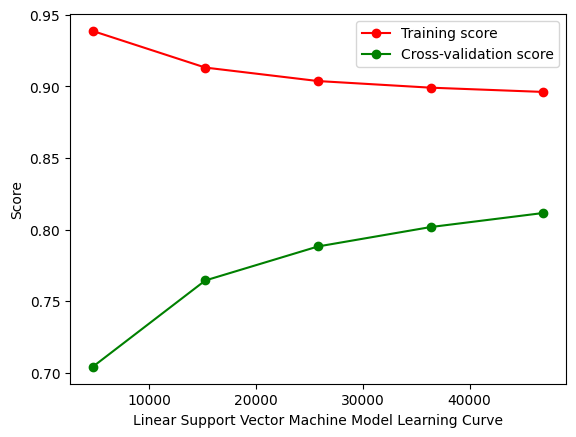

In [107]:
plot_learning_curve(clf_lsvm, X_train, Y_train, "Linear Support Vector Machine")

In [87]:
dataset = pd.read_csv('en_climate_df.csv')

X = dataset['text']
Y = dataset['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use support vector machine
from sklearn.svm import SVC
clf_svm = SVC(gamma='auto').fit(X_train, Y_train)

test_and_plot_model(clf_svm, X_test, Y_test, "Support Vector Machine")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.47      1.00      0.64     18436
     neutral       0.00      0.00      0.00      2715
    positive       0.00      0.00      0.00     17949

    accuracy                           0.47     39100
   macro avg       0.16      0.33      0.21     39100
weighted avg       0.22      0.47      0.30     39100



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_learning_curve(clf_svm, X_train, Y_train, "Support Vector Machine")

In [143]:
dataset = pd.read_csv('en_climate_df.csv')

X = dataset['text']
Y = dataset['sentiment']

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=15, train_size=0.6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

countVectorizer = CountVectorizer()
X_train = countVectorizer.fit_transform(X_train)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train = tf_transformer.transform(X_train)

# use bernoulli naive bayes
from sklearn.naive_bayes import BernoulliNB
clf_bnb_climate = BernoulliNB().fit(X_train, Y_train)


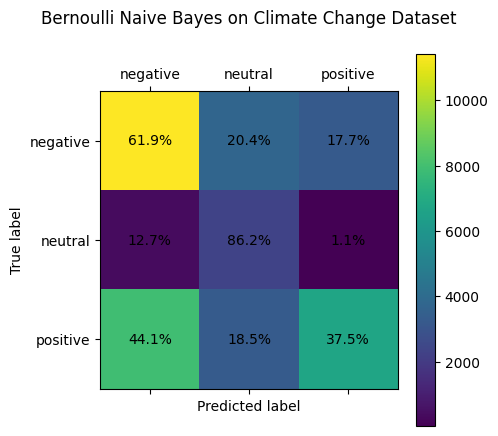

In [166]:
# plot the confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(clf, X_test, Y_test, title):
    X_new_counts = countVectorizer.transform(X_test)
    X_new_tfidf = tf_transformer.transform(X_new_counts)
    y_pred = clf.predict(X_new_tfidf)
    cm = confusion_matrix(Y_test, y_pred)
    plt.matshow(cm)
    # add some space after the title
    plt.title(title, y=1.2)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # use positive, negative, neutral as labels
    labels = ['negative', 'neutral', 'positive']
    plt.xticks([0, 1, 2], labels)
    plt.yticks([0, 1, 2], labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(x=j, y=i, s="{:.1%}".format(cm[i, j]/np.sum(cm[i, :])), va='center', ha='center')
    # save the plot as a png file
    plt.savefig(title + '.png')
    plt.show()

plot_confusion_matrix(clf_bnb_climate, X_test, Y_test, "Bernoulli Naive Bayes on Climate Change Dataset")

In [135]:
bnb_report_climate = get_classification_report(clf_bnb_climate, X_test, Y_test)

# save the classification report to a csv file
bnb_report_climate.to_csv('bnb_report_climate.csv')

              precision    recall  f1-score   support

    negative       0.58      0.62      0.60     18436
     neutral       0.25      0.86      0.39      2715
    positive       0.67      0.37      0.48     17949

    accuracy                           0.52     39100
   macro avg       0.50      0.62      0.49     39100
weighted avg       0.60      0.52      0.53     39100



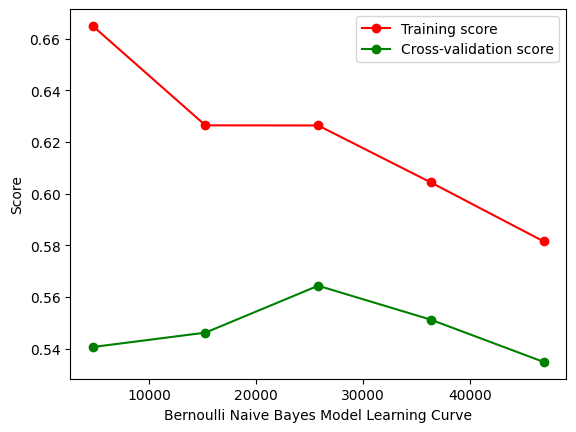

In [104]:
plot_learning_curve(clf_bnb, X_train, Y_train, "Bernoulli Naive Bayes")

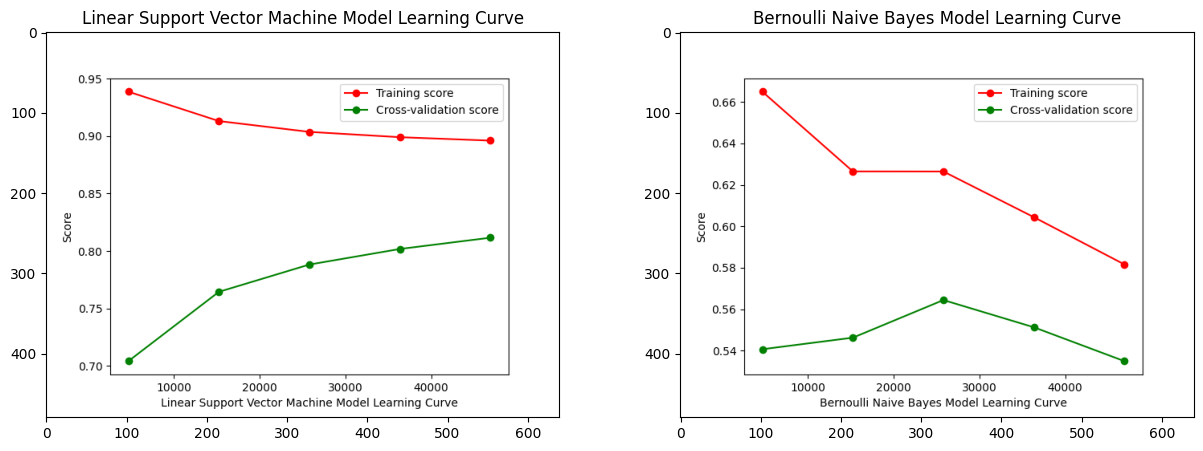

In [109]:
# generate a combined graph

from matplotlib import pyplot as plt

linear_svm_graph = plt.imread('Linear Support Vector MachineModel Learning Curve.png')
bnb_graph = plt.imread('Bernoulli Naive BayesModel Learning Curve.png')

# plot the learning curve graphs with the classification report on the same graph
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(linear_svm_graph)
ax[0].set_title('Linear Support Vector Machine Model Learning Curve')
ax[1].imshow(bnb_graph)
ax[1].set_title('Bernoulli Naive Bayes Model Learning Curve')
plt.show()
